In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.ndimage import gaussian_filter, convolve

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import cartopy.crs as ccrs
import cartopy

import xarray as xr
import glob
import time
from xarray.ufuncs import cos, deg2rad

import os
import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)
from tools.generalTools import qsat

# Functions, etc

In [3]:
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"

def climatology_era5(year1,year2,varid):
    """Compute the monthly climatology of a 3D or 4D ERA5 variable for years between year1 and year2 (included),
    year1/2 must be of the type "yyyy"
    varid gives the id of the variable in era5, e.g. '128_135_w' for omega
    mnth is an str that gives the month to be considered
    """
    path = "/global/homes/w/wboos/m3310project/wboos/era5monthlyQuentin/"
    
    era5varsum = 0
    count = int(year2)+1-int(year1)
    era5varlist = []
    for y in [str(year) for year in range(int(year1),int(year2)+1)]:
        era5var = xr.open_dataset(glob.glob(path+"*/e5.*.%s.*.%s*.nc"%(varid,y))[0])
        varname = list(era5var.data_vars)[0] #get name of the main variable, eg 'W' for omega
        era5var1 = era5var[varname]
        era5varlist.append(era5var1)
    climatology = xr.concat(era5varlist,"time").groupby("time.month").mean("time")
    return climatology

def spatial_mean(ds):
    """Compute spatial mean of a DataArray"""
    if type(ds)==int:
        return ds
    coslat = cos(deg2rad(ds.latitude))
    weight_factor = coslat / coslat.mean('latitude')
    return (ds*weight_factor).mean(['latitude','longitude'])


In [4]:
def vinteg(ds,ps):
    """Compute vertical integral of ds in pressure coordinates (integ(variable*dp/g))
    ps is the surface pressure"""
    return ((ds*(100*ds.level<ps)).integrate("level")*100)/9.81

In [5]:
ERA5M_PATH = "/global/project/projectdirs/m3310/wboos/era5monthly/"
pr_era5_all = 1000*xr.open_dataset(ERA5M_PATH+"era5_monthly_slev_1979-2019.nc").tp
pr_era5_mnthmean = pr_era5_all.groupby("time.month").mean("time")
pr_era5_mean = pr_era5_all.mean("time")

pr_trmm_all=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc").pr.rename({'lat':'latitude','lon':'longitude'})*3600*24
pr_trmm_mnthmean = pr_trmm_all.groupby("time.month").mean("time")
pr_trmm_mean = pr_trmm_mnthmean.mean('month')

In [6]:
#OROGRAPHY
orog1 = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
orog=orog1.Z.isel(time=0)/9.80665

m_per_degreelat = 6370*1e3*np.pi/180

coslat = np.cos(orog.latitude*np.pi/180.)
coslat += 1e-5*(1-1*(coslat>1e-5))

ddxorog = orog.differentiate("longitude")/(m_per_degreelat*coslat)
ddyorog = orog.differentiate("latitude")/m_per_degreelat

#latitude step in era5
dx5 = np.abs(np.array(ddxorog.latitude.isel(latitude=1)-ddxorog.latitude.isel(latitude=0)))

#LAND MASK
landmask = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)

# Daily precip / CSF data

In [ ]:
t=time.time()
q_era5_1yr = xr.open_mfdataset(CMIP6_FOLDER+"ERA5/e5.oper.an.pl/200001/e5.oper.an.pl.128_133_q*.nc",combine='nested',concat_dim="time").Q
r_era5_1yr = xr.open_mfdataset(CMIP6_FOLDER+"ERA5/e5.oper.an.pl/200001/e5.oper.an.pl.128_157_r*.nc",combine='nested',concat_dim="time").R
print(time.time()-t)
qsattest=q_era5_1yr/r_era5_1yr*100
print(time.time()-t)
vinteg_qsattest = vinteg(qsattest.isel(level=range(3,37)),ps_era5_1yr)
print(time.time()-t)
vinteg_qsattest=vinteg_qsattest.sel(latitude=slice(20,-20)).resample(time="1D").mean('time').compute()
print(time.time()-t)


0.4425997734069824
0.44612598419189453
1.4136006832122803


In [9]:
t_era5_1yr = xr.open_mfdataset(CMIP6_FOLDER+"ERA5/e5.oper.an.pl/200001/e5.oper.an.pl.128_130_t*.nc",combine='nested',concat_dim="time")

In [5]:
pr_era5_1yr = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.generated_tp/ERA5_IVT_tp_reanalysis_2010.nc")
pr_era5_1yr=pr_era5_1yr.sel(time=pr_era5_1yr['time.month']==1)

ps_era5_1yr = xr.open_mfdataset(CMIP6_FOLDER+"ERA5/e5.oper.an.sfc/200001/e5.oper.an.sfc.128_134_sp*.nc",combine='nested',concat_dim="time")
pw_era5_1yr = xr.open_mfdataset(CMIP6_FOLDER+"ERA5/e5.oper.an.sfc/200001/e5.oper.an.sfc.128_137_tcwv*.nc",combine='nested',concat_dim="time")



In [6]:
def preprocess(ds):
    varname = list(ds.data_vars)[0] #get name of the main variable, eg 'W' for omega
    da = ds[varname].sel(latitude=slice(20,-20))
    return da.resample(time="1D").mean('time')

In [7]:
t=time.time()
pr_era5_1yr=preprocess(pr_era5_1yr).compute()
ps_era5_1yr=preprocess(ps_era5_1yr).compute()
pw_era5_1yr=preprocess(pw_era5_1yr).compute()
print(time.time()-t)


16.59783625602722


In [24]:
t=time.time()
t_era5_1yr=preprocess(t_era5_1yr).compute()
print(time.time()-t)


1202.8448812961578


In [25]:
t_era5_1yr.to_netcdf("e5.oper.an.pl.128_130_t.ll025sc.20S20N.20000101_20000131.nc")

In [29]:
t=time.time()
qsat_era5_1yr = qsat(t_era5_1yr,t_era5_1yr.level).compute()
print(time.time()-t)

40.072662591934204


In [30]:
vinteg_qsat_era5_1yr = vinteg(qsat_era5_1yr.isel(level=range(3,37)),ps_era5_1yr)

In [31]:
csf = pw_era5_1yr/vinteg_qsat_era5_1yr

In [9]:
dl = 2.5
grid = da = xr.DataArray(np.zeros((int(np.ceil(40.01/dl)),int(np.ceil(360/dl)))),
                        dims=["latitude","longitude"],
                        coords={"latitude": np.arange(20,-20.01,-dl), "longitude": np.arange(0,360,dl)},
                    )

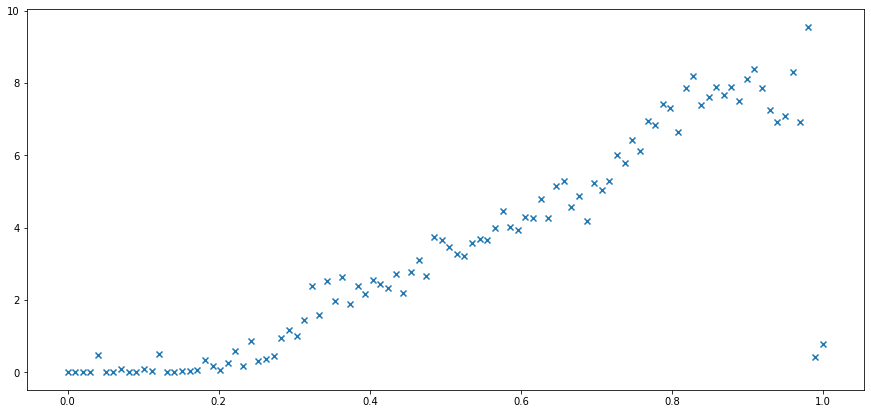

In [78]:
csf_processed = np.array(csf.interp_like(grid)).reshape(-1)
pr_processed = 24*1000*np.array(pr_era5_1yr.interp_like(grid)).reshape(-1)

fig, ax = plt.subplots(1,1,figsize=(15,7))
ax.scatter(np.linspace(0,1,100),sp.stats.binned_statistic(csf_processed,pr_processed,'mean',100).statistic,marker='x')


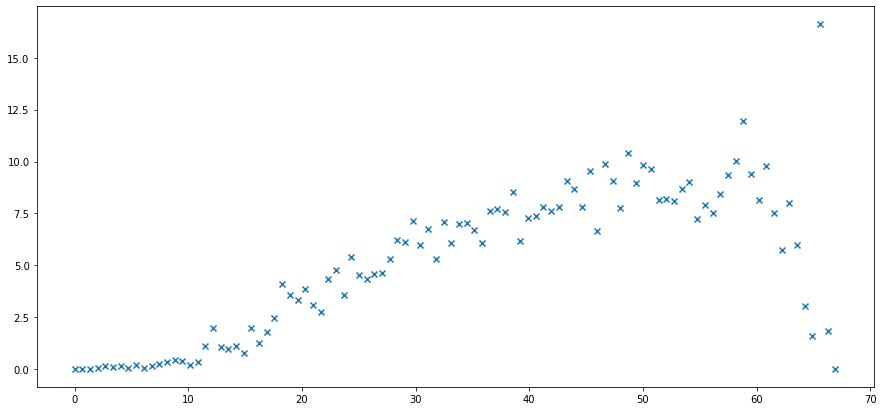

In [17]:
pw_processed = np.array(pw_era5_1yr.interp_like(grid).sel(longitude=slice(150,250))).reshape(-1)
pr_processed = 24*1000*np.array(pr_era5_1yr.interp_like(grid).sel(longitude=slice(150,250))).reshape(-1)

fig, ax = plt.subplots(1,1,figsize=(15,7))
ax.scatter(np.linspace(0,max(pw_processed),100),sp.stats.binned_statistic(pw_processed,pr_processed,'mean',100).statistic,marker='x')


# Misc

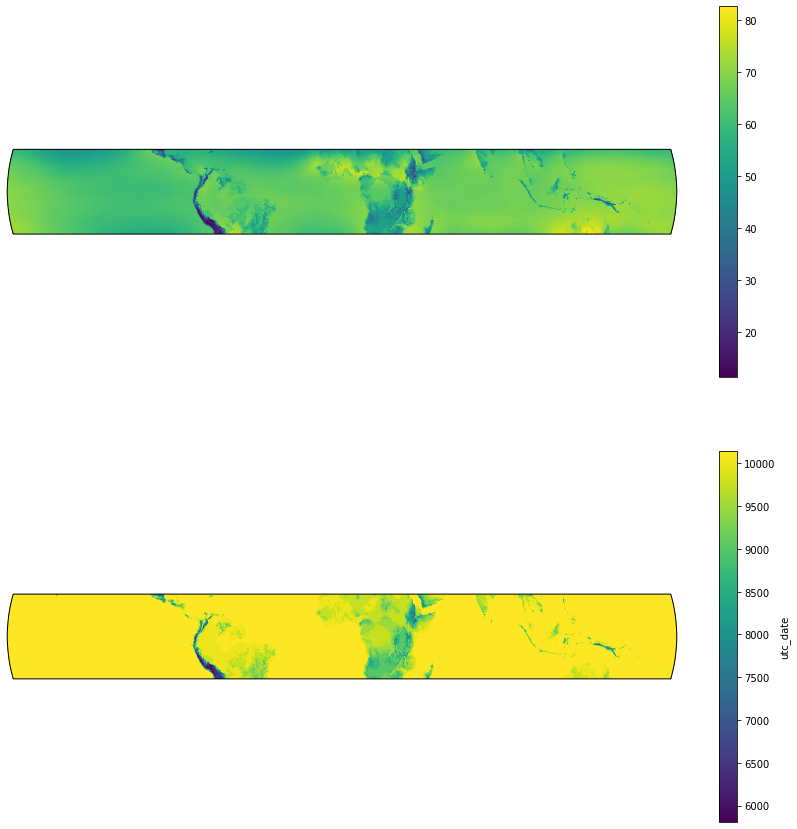

In [84]:

fig, ax = plt.subplots(2,1,figsize=(15,15),subplot_kw={'projection': ccrs.Robinson()})

vinteg_qsat_era5_1yr.mean("time").plot(ax=ax[0],transform=ccrs.PlateCarree())
vinteg_qsattest.mean("time").plot(ax=ax[1],transform=ccrs.PlateCarree())

In [86]:
q_era5_1yr

<xarray.Dataset>
Dimensions:    (latitude: 721, level: 37, longitude: 1440, time: 744)
Coordinates:
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * level      (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2000-01-01 ... 2000-01-31T23:00:00
Data variables:
    Q          (time, level, latitude, longitude) float32 dask.array<chunksize=(24, 37, 721, 1440), meta=np.ndarray>
    utc_date   (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper10 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Fri Jul 26 11:20:48 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Fri Jul 26 11:21:25 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.4 (http://nco.sf.net)